In [1]:
import numpy as np
import sys
from pathlib import Path

sys.path.append('../code/')

from mlalgos import BuildNN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `BuildNN` 
### for systematically searching over network architectures and hyperparameters

In [3]:
# Plot_Stem = 'buildnn/plots'
# Path(Plot_Stem).mkdir(parents=True,exist_ok=True)

# Save_Fig = True

## 1-d Gaussian family
### Function definition

In [4]:
def func_gauss1d(x,params):
    """ Expect x as 1-d array, params as array of shape (0,), (1,) or (2,). """
    mu = params[0] if len(params) > 0 else 0.0
    sig2 = 10**params[1] if len(params) > 1 else 1.0
    return np.exp(-0.5*(x-mu)**2/sig2)/np.sqrt(2*np.pi*sig2)

In [10]:
Shallow = False # True: shallow+wide arch; False: deep+narrow arch

### Training & testing samples

In [11]:
start_time = time()

print('Generating data for 1-d Gaussian family...')

xmin,xmax = -2.5,3.0

seed = 1983
rng = np.random.RandomState(seed)

n_x_train = 80 if Shallow else 120
xtrain = np.linspace(xmin,xmax,n_x_train)

param_mins = [-0.5,-0.1] if Shallow else [-1,-0.3] # minimum mu,lgsig2
param_maxs = [ 0.5, 0.1] if Shallow else [ 1, 0.3] # maximum mu,lgsig2

#################################################
# Training set
print('... training sample')
n_lhc_train = 30 if Shallow else 45 # no. of Latin hypercube samples
n_params = len(param_mins)

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_train = ut.gen_latin_hypercube(Nsamp=n_lhc_train,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_train = [[]]

n_train = n_lhc_train*n_x_train

X_train = np.zeros((n_train,n_params+1)) # features = {params},x; X will be transposed later
Y_train = np.zeros((1,n_train))

for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    for p in range(n_params):
        X_train[sl,p] = params_train[n,p]
    X_train[sl,-1] = xtrain
    Y_train[0,sl] = func_gauss1d(xtrain,params_train[n])

X_train = X_train.T
print('... sample of size {0:d} created'.format(n_train))
#################################################
# Testing set
print('... testing sample')
n_x_test = 40 if Shallow else 120
xtest = (xmax-xmin)*rng.random_sample(n_x_test) + xmin

n_lhc_test = 20 if Shallow else 30 # no. of Latin hypercube samples

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_test = ut.gen_latin_hypercube(Nsamp=n_lhc_test,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_test = [[]]

n_test = n_lhc_test*n_x_test

X_test = np.zeros((n_test,n_params+1)) # features = {params},x; X will be transposed later
Y_test = np.zeros((1,n_test))

for n in range(n_lhc_test):
    sl = np.s_[n*n_x_test:(n+1)*n_x_test]
    for p in range(n_params):
        X_test[sl,p] = params_test[n,p]
    X_test[sl,-1] = xtest
    Y_test[0,sl] = func_gauss1d(xtest,params_test[n])

X_test = X_test.T
print('... sample of size {0:d} created'.format(n_test))
print('... done')
ut.time_this(start_time)

Generating data for 1-d Gaussian family...
... training sample
... sample of size 5400 created
... testing sample
... sample of size 3600 created
... done
0 min 0.01 seconds



### Network setup and training

#### Non-ensembled

File_Stem: buildnn/gf1d_deep/net
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 5400 samples
... fraction 0.800 (4320 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
Initiating search... 
... cycling over 3 repetitions of 24 possible options
... setting tasks
... training using 4 process(es)
[....................] 100% done
[................... ] 99% done
... identifying and saving best network and its teststat and training params
Best test stat = 3.964e-02
Setup params:  {'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize': True, 'file_stem': 'buildnn/gf1d_deep/net', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 16, 'wt_decay': 0.0, 'n_layer': [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1], 'reg_fun': 'none', 'atypes': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu

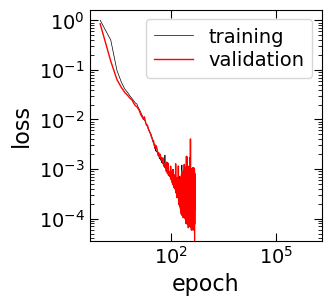

32 min 36.52 seconds



In [12]:
Build = True

Depth_Str = 'shallow' if Shallow else 'deep'
Example_Stem = 'gf1d_'+Depth_Str

File_Stem = 'buildnn/' + Example_Stem
Path(File_Stem).mkdir(parents=True,exist_ok=True) # main folder to store final network
File_Stem += '/net' 
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str              # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2                                  # minimum number of layers
Max_Layer = 4                                  # maximum number of layers
Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh','relu']                       # None or subset of ['tanh','relu','lrelu'] 
# LReluSlope = 1e-2                             # relevant if HTypes contains 'lrelu'
LRates = [1e-3,3e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0]                              # non-empty list of floats: weight decay values
N_Iter = 3                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Check_After = 100 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 4                                     # number of concurrent processes (only relevant if Parallel = True)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,parallel=Parallel,nproc=NProc,
              loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=False)
if Build:
    net,params_train,bts = bnn.trainNN()
    print('Best test stat = {0:.3e}'.format(bts))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train,bts = bnn.load_train()
    print('... best test stat: {0:.3e}'.format(bts))
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training')
plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation')
plt.legend()
plt.show()

residual = np.squeeze(net.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

#### Ensembled

In [13]:
# Build = True

# Depth_Str = 'shallow' if Shallow else 'deep'
# Example_Stem = 'gf1d_'+Depth_Str
# Example_Stem += '_ens'

# File_Stem = 'buildnn/' + Example_Stem
# Path(File_Stem).mkdir(parents=True,exist_ok=True) # main folder to store final ensemble object
# File_Stem += '/neo' 
# print('File_Stem:',File_Stem)

# Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
#                                                # remaining used for arch and hyperparam comparisons.
# Val_Frac = 0.2                                 # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
# Arch_Type = 'emulator:'+Depth_Str              # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
# Min_Layer = 2                                  # minimum number of layers
# Max_Layer = 4                                  # maximum number of layers
# Max_Ex = [7,17] if Shallow else [4,6]          # int or list of ints. number of nodes in excess of input dimension 
#                                                # (currently forced to be constant across layers)
# HTypes = ['tanh','relu']                       # None or subset of ['tanh','relu','lrelu'] 
# # LReluSlope = 1e-2                             # relevant if HTypes contains 'lrelu'
# LRates = [1e-3,3e-3]                           # None or list of floats: learning rates
# Wt_Decays = [0.0]                              # non-empty list of floats: weight decay values
# N_Iter = 3                                     # number of iterations for each choice of arch and hyperparams
# Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
# Seed = None                                    # None or int, random number seed.
# Check_After = 100 if Shallow else 1000         # epoch after which to activate validation (early stopping) checks
# Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
#                                                # relevant for regression (square/hinge loss).

# start_time = time()
# bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,
#               val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,
#               loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)
# if Build:
#     neo,params_train,mtl = bnn.trainNN()
#     print('Best mean test loss = {0:.3e}'.format(mtl))
#     print('Setup params: ',neo.params)
#     print('Training params: ',params_train)
# else:
#     neo = bnn.load() # network ensemble object
#     print('Loaded ensembled network with')
#     print('...    setup params: ',neo.params)
#     params_train = bnn.load_train()
#     print('... training params: ',params_train)

# print('No. of free params optimized:')
# for n in range(len(neo.nets)):
#     net = neo.nets[n]
#     print('... net_{0:d} = {1:d}\n'.format(n,net.calc_N_freeparams()))

# plt.figure(figsize=(3,3))
# plt.yscale('log')
# plt.xscale('log')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# for n in range(len(neo.nets)):
#     net = neo.nets[n]
#     plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
#     plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
# plt.legend()
# plt.show()

# residual_ens = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)

# ut.time_this(start_time)

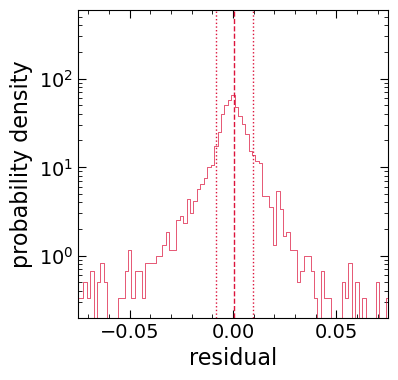

median +- 1sigma: 0.0004 + 0.0092 - 0.0088


In [14]:
res_16pc = np.percentile(residual,16)
res_med  = np.median(residual)
res_84pc = np.percentile(residual,84)

bins = np.linspace(-0.25,0.25,301)
bin_mid = 0.5*(bins[1:]+bins[:-1])
hist,bins = np.histogram(residual,bins=bins,density=False)
hist = hist/residual.size/(bins[1]-bins[0])

plt.figure(figsize=(4,4))
plt.xlim(-0.075,0.075)
plt.ylim(2e-1,6e2)
plt.yscale('log')
plt.xlabel('residual')
plt.ylabel('probability density')
plt.plot(bin_mid,hist,'-',c='crimson',lw=0.5,drawstyle='steps')
plt.axvline(res_med,c='crimson',ls='--',lw=1)
plt.axvline(res_16pc,c='crimson',ls=':',lw=1)
plt.axvline(res_84pc,c='crimson',ls=':',lw=1)
plt.minorticks_on()
plt.show()

print('median +- 1sigma: {0:.4f} + {1:.4f} - {2:.4f}'.format(res_med,res_84pc-res_med,res_med-res_16pc))